<CENTER><div style="display: flex; background-color: RGB(255,204,50);" >
<h1 style="margin: auto; padding: 30px; ">NATURAL LANGUAGE PROCESSING WITH DISASTER TWEETS<br><br>ANALYSE EXPLORATOIRE</h1>
</div>

## **Résumé**
Dans ce document, nous allons élaborer des modèles machine learning permettant de prédire le fait qu'un tweet annonce un désastre ou non.
Cette analyse se base sur des données de [Kaggle de tweets](https://www.kaggle.com/competitions/nlp-getting-started/data) composée comme suit :
- `id` - identifiant unique de chaque tweet
- `text` - le contenu du tweet
- `location` - le lieu de provenance du tweet
- `keyword` - un mot clé particulier du tweet
- `target` - indique si le tweet est en rapport avec un désastre (1) ou non (0)

Ce travail suit le plan suivant :    
- Importation et exploration des données
- Création de corpus
- Nétoyage du texte (suppression de la ponctuation, des caractères spéciaux, des chiffres, des espaces supplémentaires, etc)
- Tokennisation (n_gram - 1_gram, 2_gram, 3_gram -)
- Suppression des Stopwords ; Lemmatisation
- Vectorisation
- Prédiction (algorithme, optimisation des hyperparamètres, analyse de la modélisation)
- Evaluation des modèles & Choix du meilleur modèle

<div style="background-color: RGB(51,165,182);" >
<h1 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies et chargement de la base </h1>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.1 Importation des librairies</h2>
</div>

In [105]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.datasets import fetch_20newsgroups
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             roc_auc_score,
                             confusion_matrix,
                            )
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
import warnings
import pyLDAvis.gensim_models
import pyLDAvis
from joblib import dump
# filter warnings
warnings.filterwarnings('ignore')

<div style="border: 1px solid RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.2 - Paramètres</h2>
</div>

In [106]:
# Définition du répertoire de travail
HOME_DIR = Path.cwd().parent
DATA_DIR = Path(HOME_DIR, "data")
print(f"Work directory: {HOME_DIR} \nData directory: {DATA_DIR}")

Work directory: C:\Users\user\Documents\Jupyter\ML2\Projet 
Data directory: C:\Users\user\Documents\Jupyter\ML2\Projet\data


<div style="border: 1px solid RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.3 - Chargement de la base</h2>
</div>

In [107]:
# importation de la base
train_data = pd.read_csv(Path(DATA_DIR, "train.csv"), sep=",")
test_data = pd.read_csv(Path(DATA_DIR, "test.csv"), sep=",")

<div style="background-color: RGB(51,165,182);" >
<h1 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Description du jeu de données</h1>
</div>

In [108]:
train_data.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [109]:
test_data.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

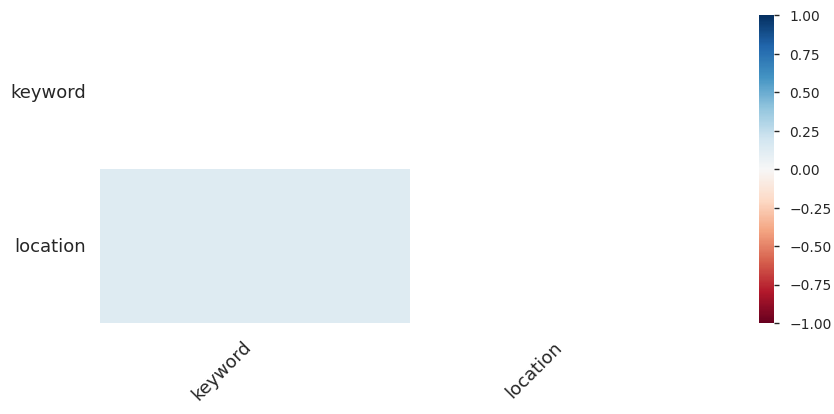

In [110]:
train_profile = ProfileReport(train_data, title="Profil du jeu de données d'entraînement")
train_profile.to_notebook_iframe()

La base utilisée ici contient un total de 7613 tweets.

Les variables `keyword` et `location` contiennent respectivement 0.8% et 33.3% de valeurs manquantes. On note égalemnent un total de 3341 localisations distincts et 221 mots clés distincts. Cependant, ces informations ne seront pas utilisées dans l'analyse des tweets, la modélisation et la prédiction des désatre annoncés dans les tweets. Ces 2 variables seront par conséquent supprimées.

En ce qui concerne les tweets, on note la présence de 1.6% de tweets doublons. De plus, il y a une forte présence des mots "the", "a", "to", "in", "of", "and", "for", "on" d'après le diagramme des mots. Ces derniers sont en général considérés comme des stopwords de la langue anglaise. Cela nous amène donc à au nétoyage du corpus présent.

In [111]:
train_data['target_name'] = train_data['target'].replace({0: 'nodisaster', 1: 'disaster'})
train_data.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target target_name  
0       1    disaster  
1       1    disaster  
2       1    disaster  
3       1    disaster  
4       1    disaster

**Répartition des cibles**

In [112]:
label_distribution = train_data[["target", "target_name"]].value_counts(normalize = True).mul(100).round(2)
label_distribution

target  target_name
0       nodisaster     57.03
1       disaster       42.97
Name: proportion, dtype: float64

<Axes: xlabel='target,target_name'>

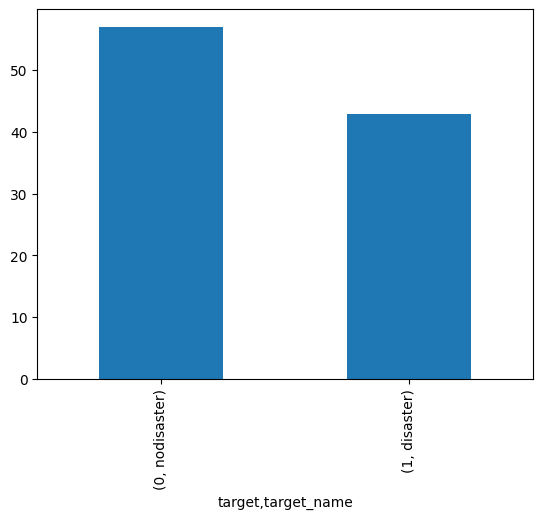

In [113]:
%matplotlib inline
label_distribution.plot(kind="bar", )

La répartition n'est pas déséquilibrée. Elle est d'ailleurs assez égalitaire par rapport aux 2 cibles (distater et nodisaster)

In [114]:
#keyword_distribution = train_data[["keyword"]].value_counts(normalize = True).mul(100).round(2)
#location_distribution = train_data[["location"]].value_counts(normalize = True).mul(100).round(2)

#print(keyword_distribution)
#print("\n")
#print(location_distribution)

<div style="background-color: RGB(51,165,182);" >
<h1 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Prétaitement</h1>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1 `Keyword` détermine-t-elle `target`</h2>
</div>

In [115]:
# Convertir les colonnes en chaînes de caractères
train_data['keyword'] = train_data['keyword'].astype(str)
train_data['text'] = train_data['text'].astype(str)

# Fonction pour vérifier la présence du mot dans le texte
def word_in_text(row):
    return int(row['keyword'].lower() in row['text'].lower())

# Appliquer la fonction à chaque ligne du DataFrame
train_data['keyword_in_text'] = train_data.apply(word_in_text, axis=1)

train_data.head()

id keyword location                                               text  \
0   1     nan      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     nan      NaN             Forest fire near La Ronge Sask. Canada   
2   5     nan      NaN  All residents asked to 'shelter in place' are ...   
3   6     nan      NaN  13,000 people receive #wildfires evacuation or...   
4   7     nan      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target target_name  keyword_in_text  
0       1    disaster                0  
1       1    disaster                0  
2       1    disaster                0  
3       1    disaster                0  
4       1    disaster                0

In [116]:
train_data[train_data["keyword"] != "nan"]['keyword_in_text'].value_counts(normalize= True)

keyword_in_text
1    0.790916
0    0.209084
Name: proportion, dtype: float64

Dans 79% des cas, le mot clé est dans le tweet. Il se pourrait qu'il identifie suffisamment bien la nature "disaster" ou "nodisaster" du tweet

In [117]:
disaster_keyword = train_data[train_data['target'] == 1]['keyword']
nodisaster_keyword = train_data[train_data['target'] == 0]['keyword']
#nodisaster_keyword.value_counts()
#disaster_keyword.value_counts()

In [118]:
# Convertir les listes en ensembles
set1 = set(disaster_keyword)
set2 = set(nodisaster_keyword)

# Trouver les mots en commun
common_words = set1 & set2

# Compter le nombre de mots en commun
num_common_words = len(common_words)

print("Mots en commun:", common_words)
print("Nombre de mots en commun:", num_common_words)
print("Nombre de keyword en tweet disaster:", len(disaster_keyword.unique()))
print("Nombre de keyword en tweet nodisaster:", nodisaster_keyword.nunique())

Mots en commun: {'natural%20disaster', 'catastrophe', 'electrocuted', 'drowning', 'seismic', 'obliteration', 'flood', 'buildings%20on%20fire', 'threat', 'hijacking', 'screaming', 'terrorist', 'trapped', 'attacked', 'danger', 'displaced', 'landslide', 'traumatised', 'war%20zone', 'flames', 'hostage', 'quarantine', 'windstorm', 'blown%20up', 'first%20responders', 'accident', 'panicking', 'body%20bagging', 'evacuate', 'mudslide', 'hijack', 'nuclear%20disaster', 'smoke', 'oil%20spill', 'obliterate', 'collapse', 'rioting', 'typhoon', 'hellfire', 'injuries', 'bleeding', 'hailstorm', 'emergency%20plan', 'eyewitness', 'bioterror', 'demolition', 'deaths', 'collide', 'injury', 'devastated', 'bridge%20collapse', 'disaster', 'stretcher', 'outbreak', 'death', 'ablaze', 'engulfed', 'explode', 'curfew', 'terrorism', 'destruction', 'nan', 'blaze', 'dead', 'inundated', 'airplane%20accident', 'pandemonium', 'survived', 'emergency', 'catastrophic', 'mass%20murderer', 'mayhem', 'blight', 'upheaval', 'clif

Il n'y a pas une grande différence entre les mots clés des tweets de chaque catégorie.

In [119]:
from scipy.stats import chi2_contingency
import numpy as np

# Créer une table de contingence
contingency_table = pd.crosstab(train_data['keyword'], train_data['target'])
# Afficher la table de contingence
print("Table de contingence :")
print(contingency_table)
# Calculer le test du chi carré
chi2, p, dof, expected = chi2_contingency(contingency_table)
# Afficher les résultats
print(f"\nChi2: {chi2}, p-value: {p}")

# Calculer le V de Cramer
n = contingency_table.sum().sum()  # Nombre total d'échantillons
min_dim = min(contingency_table.shape) - 1  # La plus petite dimension de la table de contingence
cramers_v = np.sqrt(chi2 / (n * min_dim))
# Affichage des résultats
print(f"\nV de Cramer: {cramers_v}")


Table de contingence :
target                0   1
keyword                    
ablaze               23  13
accident             11  24
aftershock           34   0
airplane%20accident   5  30
ambulance            18  20
...                  ..  ..
wounded              11  26
wounds               23  10
wreck                30   7
wreckage              0  39
wrecked              36   3

[222 rows x 2 columns]

Chi2: 2282.777332726426, p-value: 0.0

V de Cramer: 0.5475879225004032


In [120]:
from scipy.stats import chi2_contingency
import numpy as np

# Créer une table de contingence
contingency_table = pd.crosstab(train_data['keyword'], train_data['target_name'])
# Afficher la table de contingence
print("Table de contingence :")
print(contingency_table)
# Calculer le test du chi carré
chi2, p, dof, expected = chi2_contingency(contingency_table)
# Afficher les résultats
print(f"\nChi2: {chi2}, p-value: {p}")

# Calculer le V de Cramer
n = contingency_table.sum().sum()  # Nombre total d'échantillons
min_dim = min(contingency_table.shape) - 1  # La plus petite dimension de la table de contingence
cramers_v = np.sqrt(chi2 / (n * min_dim))
# Afficher les résultats
print(f"\nV de Cramer: {cramers_v}")

Table de contingence :
target_name          disaster  nodisaster
keyword                                  
ablaze                     13          23
accident                   24          11
aftershock                  0          34
airplane%20accident        30           5
ambulance                  20          18
...                       ...         ...
wounded                    26          11
wounds                     10          23
wreck                       7          30
wreckage                   39           0
wrecked                     3          36

[222 rows x 2 columns]

Chi2: 2282.777332726426, p-value: 0.0

V de Cramer: 0.5475879225004032


Le test de Chi2 révèle une dépendance entre les mots clés des tweets et la nature "disaster" ou "nodisaster" du tweets. Le V de Cramer estime l'intensité de cette relation à seulement 54.76%

<div style="border: 1px solid RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.2 Corpus</h2>
</div>

In [121]:
u_data = train_data.copy()
train_data = u_data[["id", "text",	"target",	"target_name"]]
train_data = train_data.drop_duplicates(subset='text', keep='first', inplace=False)
train_data = train_data.reset_index(drop=True)

In [122]:
duplicated_rows = u_data[u_data.duplicated(subset='text', keep=False)]
duplicated_rows

id     keyword        location  \
40       59      ablaze  Live On Webcam   
48       68      ablaze  Live On Webcam   
106     156  aftershock              US   
115     165  aftershock              US   
118     171  aftershock     Switzerland   
...     ...         ...             ...   
7600  10855         nan             NaN   
7607  10867         nan             NaN   
7609  10870         nan             NaN   
7610  10871         nan             NaN   
7611  10872         nan             NaN   

                                                   text  target target_name  \
40    Check these out: http://t.co/rOI2NSmEJJ http:/...       0  nodisaster   
48    Check these out: http://t.co/rOI2NSmEJJ http:/...       0  nodisaster   
106   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0  nodisaster   
115   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0  nodisaster   
118   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...       0  nodisaster   
...                                                 ...     ...         ...   
7600  Evacuation order lifted for town of Roosevelt:...       1    disaster   
7607  #stormchase Violent Record Breaking EF-5 El Re...       1    disaster   
7609  @aria_ahrary @TheTawniest The out of control w...       1    disaster   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1    disaster   
7611  Police investigating after an e-bike collided ...       1    disaster   

      keyword_in_text  
40                  0  
48                  0  
106                 1  
115                 1  
118                 1  
...               ...  
7600                0  
7607                0  
7609                0  
7610                0  
7611                0  

[179 rows x 7 columns]

**Représentation**

In [123]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

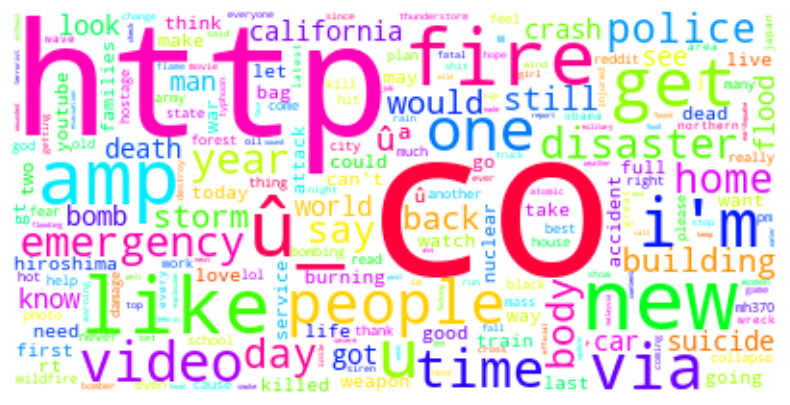

In [124]:
# Create a word_cloud from words and frequencies.

# get all verbatim
all_text = " ".join(train_data.text.str.lower())
words_frequency = Counter(all_text.split())

# stopwords of english language
stopwords_nltk = set(stopwords.words('english'))

# function for world cloud
def display_wordcloud(corpus, title=""):
    plt.figure(figsize=(10, 5))
    wc = WordCloud(background_color="white",
                   max_words=1000,
                   colormap='hsv',
                   stopwords=stopwords_nltk,
                   collocations=False)
    # generate word cloud
    #wc.generate_from_frequencies(words_frequency)
    wc.generate_from_text(corpus)
    plt.imshow(wc, interpolation="bilinear")
    plt.title(title)
    plt.axis("off");

# word cloud displaying
display_wordcloud(corpus=all_text)

Empty DataFrame
Columns: []
Index: []

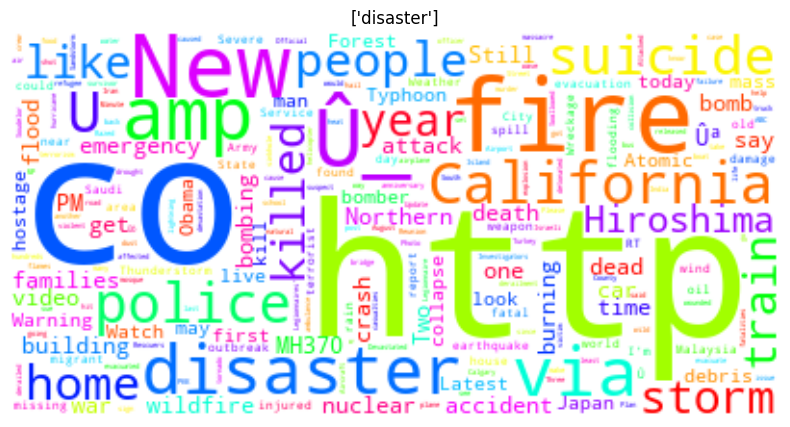

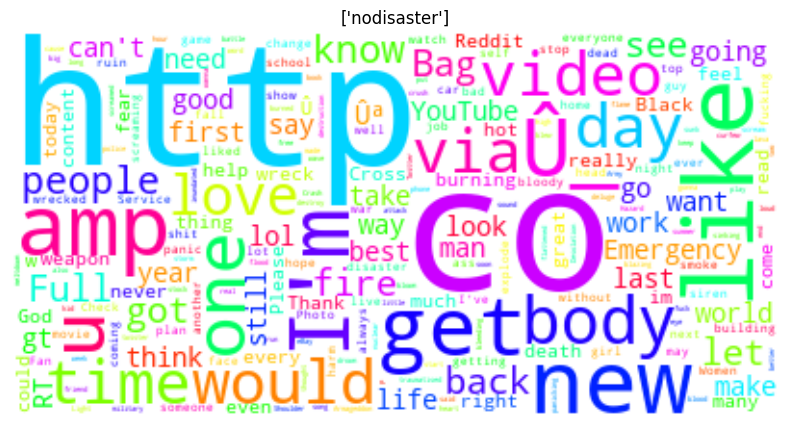

In [125]:
# wordcloud by target
train_data.groupby("target_name").apply(
    lambda group: display_wordcloud(" ".join(group.text), title=group.target_name.unique()))

<div style="border: 1px solid RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.3 Nétoyage, stopwords, lemmatisation, stemmatisation, tokennisation</h2>
</div>

***Function de preprocessing du texte***

In [126]:
def preprocess_text(text, language="english", stopwords=None, normalizer="stem"):

    valid_normalizer = (None, "stem", "lemma")
    if not normalizer in valid_normalizer:
        raise ValueError(f"`normalizer` must be in `{valid_normalizer}`")
    # lower case
    text = text.lower()

    # delete html balise
    # We can also use BeautifulSoup package to get the text from HTML document
    text = re.sub(re.compile('<.*?>'), '', text)

    # remove url
    text = re.sub(r'(http|www)\S*', '', text)

    # delete email
    text = re.sub(r"\S*@\S*\s*", "", text)

    # delete special character
    text = re.sub(r'[^\w\s]', '', text)

    # delete number
    text = re.sub(r'[0-9]+','', text).strip()

    # tokenizer
    text_tokens = word_tokenize(text)

    # remove stopword
    if isinstance(stopwords, (set, list, tuple)):
        # split sentence word by word
        text_tokens = [word for word in text_tokens if word not in stopwords]

    # stem string: snowball stemmer
    if normalizer == "stem":
        stemmer = SnowballStemmer(language, ignore_stopwords=True)
        text_tokens = [stemmer.stem(wrd) for wrd in text_tokens]
    elif normalizer == "lemma":
        lemmatizer = WordNetLemmatizer()
        text_tokens = [lemmatizer.lemmatize(wrd) for wrd in text_tokens]

    return " ".join(text_tokens)

In [127]:
!pip install vaderSentiment
!pip install --upgrade vaderSentiment
!pip install pylexique

***Functions de caracteristiques du texte***

In [128]:
!pip install afinn

In [129]:
from afinn import Afinn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def findLink(text):
    return len(re.findall(r'(http|www)\S*', text))

def findMail(text):
    return len(re.findall(r"\S*@\S*\s*", text))

def findQuote(text):
    return len(re.findall(r'"[^"]+"', text))

def findHashtag(text):
    return len(re.findall(r'#\w+', text))

def findCAPSLOCK(text):
    return len(re.findall(r'\b[A-Z]{2,}\b', text))

def find_chain_CAPSLOCK(text):
    return len(re.findall(r'[A-Z]{2,}', text))

def find_exclamation(text):
    return len(re.findall(r'!', text))

def find_chain_exclamation(text):
    return len(re.findall(r'!{2,}', text))

def find_interogation(text):
    return len(re.findall(r'\?', text))

def find_etc(text):
    return len(re.findall(r'\betc\b', text))

def sentiment_category(score):
    if score < -0.4:
        return 'negative'
    elif score > 0.4:
        return 'positive'
    else:
        return 'neutral'

def text_caract(X):
    X_processed = X.copy()
    X_processed['links'] = X['text'].apply(lambda x: findLink(x))
    X_processed['mails'] = X['text'].apply(lambda x: findMail(x))
    X_processed['quotes'] = X['text'].apply(lambda x: findQuote(x))
    X_processed['hashtags'] = X['text'].apply(lambda x: findHashtag(x))
    X_processed['capslock'] = X['text'].apply(lambda x: findCAPSLOCK(x))
    X_processed['chain_capslock'] = X['text'].apply(lambda x: find_chain_CAPSLOCK(x))
    X_processed['exclamation'] = X['text'].apply(lambda x: find_exclamation(x))
    X_processed['chain_exclamation'] = X['text'].apply(lambda x: find_chain_exclamation(x))
    X_processed['interogation'] = X['text'].apply(lambda x: find_interogation(x))
    X_processed['etc'] = X['text'].apply(lambda x: find_etc(x))
    X_processed['nb_caracter'] = X['text'].apply(len)
    X_processed['afinn'] = X['text'].apply(lambda text: Afinn().score(text))
    X_processed['afinn_normalized'] = (X_processed['afinn'] - X_processed['afinn'].mean()) / X_processed['afinn'].std() # Normalisation
    X_processed['sentiment_score'] = X['text'].apply(lambda text: SentimentIntensityAnalyzer().polarity_scores(text)['compound'])
    X_processed['sentiment'] = X_processed['sentiment_score'].apply(sentiment_category)
    return X_processed

***Base avec les nouvelles caractéristiques***

In [130]:
base_init = train_data.copy()
train_data = text_caract(train_data)
train_data

id                                               text  target  \
0         1  Our Deeds are the Reason of this #earthquake M...       1   
1         4             Forest fire near La Ronge Sask. Canada       1   
2         5  All residents asked to 'shelter in place' are ...       1   
3         6  13,000 people receive #wildfires evacuation or...       1   
4         7  Just got sent this photo from Ruby #Alaska as ...       1   
...     ...                                                ...     ...   
7498  10863  #WorldNews Fallen powerlines on G:link tram: U...       1   
7499  10864  on the flip side I'm at Walmart and there is a...       1   
7500  10866  Suicide bomber kills 15 in Saudi security site...       1   
7501  10869  Two giant cranes holding a bridge collapse int...       1   
7502  10873  The Latest: More Homes Razed by Northern Calif...       1   

     target_name  links  mails  quotes  hashtags  capslock  chain_capslock  \
0       disaster      0      0       0         1         1               1   
1       disaster      0      0       0         0         0               0   
2       disaster      0      0       0         0         0               0   
3       disaster      0      0       0         1         0               0   
4       disaster      0      0       0         2         0               0   
...          ...    ...    ...     ...       ...       ...             ...   
7498    disaster      1      0       0         1         2               3   
7499    disaster      0      0       0         0         0               0   
7500    disaster      1      0       0         0         0               0   
7501    disaster      1      0       0         0         0               2   
7502    disaster      1      0       0         0         1               1   

      exclamation  chain_exclamation  interogation  etc  nb_caracter  afinn  \
0               0                  0             0    0           69    1.0   
1               0                  0             0    0           38   -2.0   
2               0                  0             0    0          133   -2.0   
3               0                  0             0    0           65   -1.0   
4               0                  0             0    0           88    0.0   
...           ...                ...           ...  ...          ...    ...   
7498            0                  0             0    0          136   -5.0   
7499            0                  0             0    0          114   -2.0   
7500            0                  0             0    0          121   -5.0   
7501            0                  0             0    0           83   -2.0   
7502            0                  0             0    0           94    0.0   

      afinn_normalized  sentiment_score sentiment  
0             0.705087           0.2732   neutral  
1            -0.312729          -0.3400   neutral  
2            -0.312729          -0.2960   neutral  
3             0.026543           0.0000   neutral  
4             0.365815           0.0000   neutral  
...                ...              ...       ...  
7498         -1.330544          -0.6841  negative  
7499         -0.312729          -0.4939  negative  
7500         -1.330544          -0.7650  negative  
7501         -0.312729          -0.4939  negative  
7502          0.365815           0.0000   neutral  

[7503 rows x 19 columns]

In [131]:
train_data[['links', 'mails', 'quotes', 'hashtags', 'target', 'capslock', 'chain_capslock', 'exclamation', 'chain_exclamation', 'interogation', 'nb_caracter', 'afinn', 'sentiment_score']].groupby(['target']).sum()

links  mails  quotes  hashtags  capslock  chain_capslock  exclamation  \
target                                                                          
0        2198   1842       0      1647      2713            5292          835   
1        2494    890       0      1592      2106            4972          324   

        chain_exclamation  interogation  nb_caracter   afinn  sentiment_score  
target                                                                         
0                     108          2358       411580 -2117.0        -224.5697  
1                      40           751       345327 -5973.0        -853.7981

***Formation du corpus***

In [132]:
%%time
# add new column for sanitizing
train_data["text_sanitize"] = train_data.text.apply(preprocess_text, stopwords=stopwords_nltk, normalizer=None)
train_data["text_sanitize_stem"] = train_data.text.apply(preprocess_text, stopwords=stopwords_nltk, normalizer="stem")
train_data["text_sanitize_lemma"] = train_data.text.apply(preprocess_text, stopwords=stopwords_nltk, normalizer="lemma")
train_data["text_sanitize_lemma_stem"] = train_data.text_sanitize_lemma.apply(preprocess_text, stopwords=stopwords_nltk, normalizer="stem")

CPU times: total: 17.4 s
Wall time: 17.5 s


***Représentation du corpus***

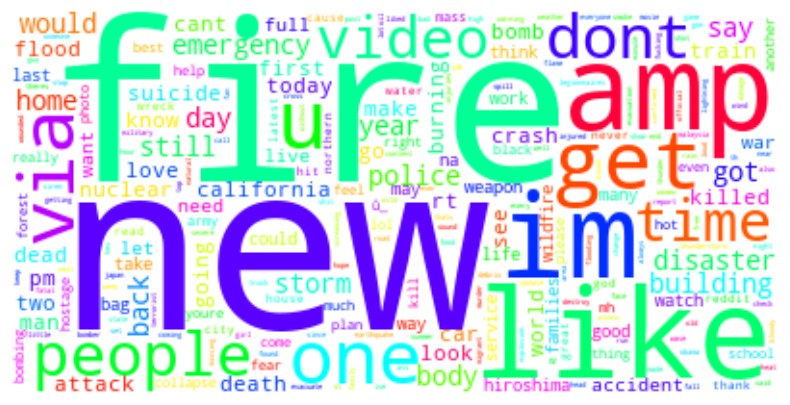

In [133]:
all_text_sanitize = " ".join(train_data.text_sanitize)
display_wordcloud(corpus=all_text_sanitize)

Empty DataFrame
Columns: []
Index: []

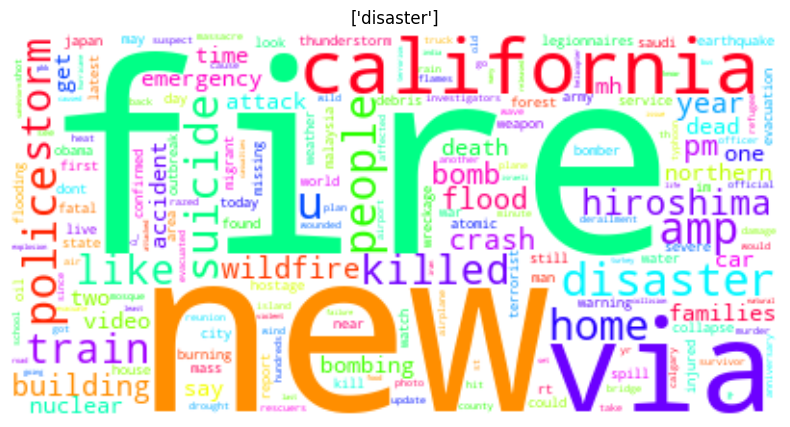

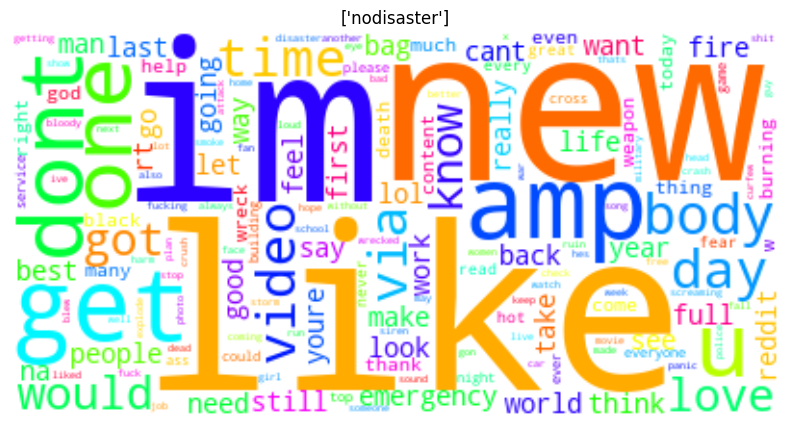

In [134]:
train_data.groupby("target_name").apply(
    lambda group: display_wordcloud(" ".join(group.text_sanitize), title=group.target_name.unique()))

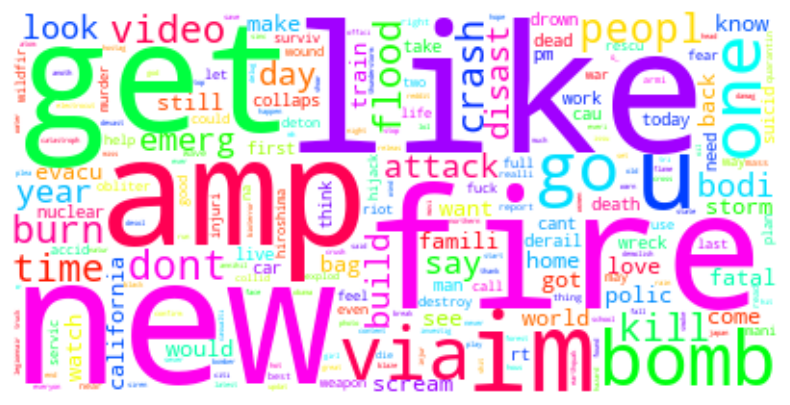

In [135]:
all_text_sanitize_stem = " ".join(train_data.text_sanitize_stem)
display_wordcloud(corpus=all_text_sanitize_stem)

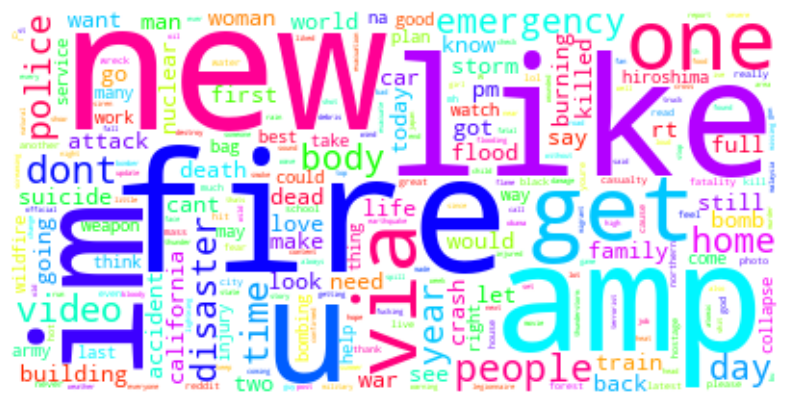

In [136]:
all_text_sanitize_lemma = " ".join(train_data.text_sanitize_lemma)
display_wordcloud(corpus=all_text_sanitize_lemma)

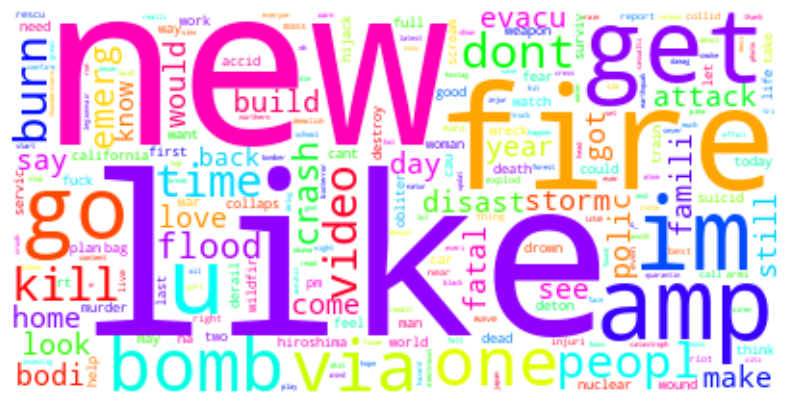

In [137]:
all_text_sanitize_lemma_stem = " ".join(train_data.text_sanitize_lemma_stem)
display_wordcloud(corpus=all_text_sanitize_lemma_stem)

***Exportation de la base utile***

In [138]:
chemin_vers_fichier = Path(DATA_DIR, "UsefulData.csv")
train_data.to_csv(chemin_vers_fichier)

In [139]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.makedirs('/content/drive/MyDrive/Colab Notebooks/Projet ML2/train_data', exist_ok=True)

# train_data.to_csv(
#     '/content/drive/MyDrive/Colab Notebooks/Projet ML2/train_data/UsefulData.csv',  # Nom du fichier
#     index=False,          # Ne pas écrire l'index
#     sep=',',              # Séparateur de champ (par défaut ',')
#     encoding='utf-8',     # Encodage du fichier
# )